# Capstone_height

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

# 1.0 EDA

#### The first step is to extract the hour, day, and month from the time series data. Then use the four-time periods of each day; Upper, middle and lower part of each month; and the four quarters of each year as bin, to divide the time continuous variable into category variables, and check if there are NaN.

In [3]:
# extract the hour, day, and month
df = pd.read_csv('ocean-waves-full.csv')
time_series = pd.to_datetime(df['DateTime'])
df['month'] = time_series.dt.month
df['day'] = time_series.dt.day
df['hour'] = time_series.dt.hour

del df['DateTime']
del df['CottPeakPeriod']
del df['CottDirection']

order = ['month', 'day', 'hour', 'RottHeight', 'RottPeakPeriod', 'RottDirection', 'CottHeight']
df = df[order]
print(df.describe())

nan_sum = df.isna().sum()  # check if there are Nan
print(nan_sum)

              month           day          hour    RottHeight  RottPeakPeriod  \
count  60245.000000  60245.000000  60245.000000  60245.000000    60245.000000   
mean       6.123861     15.755781     11.489833      2.203114       12.632240   
std        3.447934      8.764957      6.918732      0.945040        2.589528   
min        1.000000      1.000000      0.000000      0.500000        2.941176   
25%        3.000000      8.000000      5.000000      1.570000       11.111111   
50%        6.000000     16.000000     11.000000      1.990000       12.500000   
75%        9.000000     23.000000     17.000000      2.570000       14.285714   
max       12.000000     31.000000     23.000000      8.660000       28.571429   

       RottDirection    CottHeight  
count   60245.000000  60245.000000  
mean      249.977376      1.004987  
std        16.324608      0.460893  
min         1.406250      0.190000  
25%       244.687500      0.690000  
50%       250.312500      0.890000  
75%       2

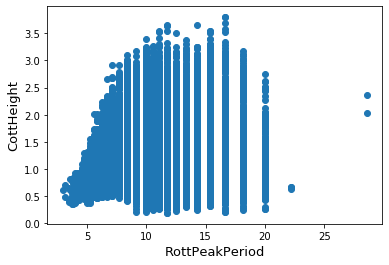

In [4]:
# there are no significant outlier need to be removed 
fig, ax = plt.subplots()
ax.scatter(x = df['RottPeakPeriod'], y = df['CottHeight'])
plt.xlabel('RottPeakPeriod', fontsize=13)
plt.ylabel('CottHeight', fontsize=13)
plt.draw()

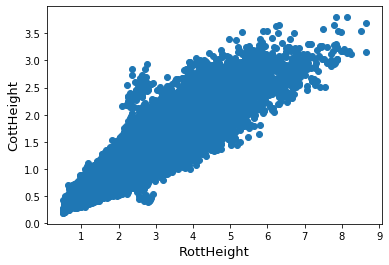

In [5]:
fig, ax = plt.subplots()
ax.scatter(x = df['RottHeight'], y = df['CottHeight'])
plt.xlabel('RottHeight', fontsize=13)
plt.ylabel('CottHeight', fontsize=13)
plt.draw()

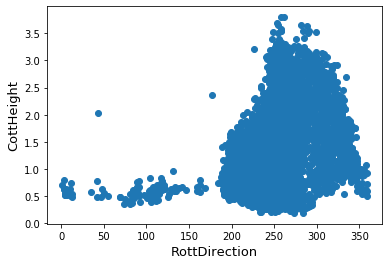

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = df['RottDirection'], y = df['CottHeight'])
plt.xlabel('RottDirection', fontsize=13)
plt.ylabel('CottHeight', fontsize=13)
plt.draw()

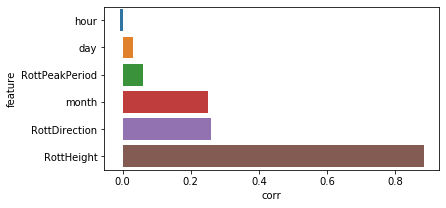

In [7]:
# Check correlation of every feature with  target
features = ['month', 'day', 'hour', 'RottHeight', 'RottPeakPeriod', 'RottDirection']
spr = pd.DataFrame()
spr['feature'] = features
spr['corr'] = [df[f].corr(df['CottHeight'], 'spearman') for f in features]

spr = spr.sort_values('corr')
plt.figure(figsize=(6, 0.5*len(features)))
sns.barplot(data=spr, y='feature', x='corr', orient='h')
plt.show()

In [8]:
# use bin method to treat time feature as category variable
# After applying to the model, we found that the "bins of hour" almost has no effect on the model result,
# so we remove it to reduce dimension in case of overfitting. 

bins_of_month = [0, 4 ,7, 9, 13]
df['month'] = pd.cut(df['month'], bins_of_month, labels=[1, 2, 3, 4])

bins_of_day = [0, 10 ,20, 32]
df['day'] = pd.cut(df['day'], bins_of_day, labels=[1, 2, 3])

# bins_of_hour = [-1, 6 ,12, 18, 25]
# df['hour'] = pd.cut(df['hour'], bins_of_hour, labels=[1, 2, 3,4])
del df['hour'] 

print(df.describe())
nan_sum = df.isna().sum()  # check if there are Nan
print(nan_sum)

         RottHeight  RottPeakPeriod  RottDirection    CottHeight
count  60245.000000    60245.000000   60245.000000  60245.000000
mean       2.203114       12.632240     249.977376      1.004987
std        0.945040        2.589528      16.324608      0.460893
min        0.500000        2.941176       1.406250      0.190000
25%        1.570000       11.111111     244.687500      0.690000
50%        1.990000       12.500000     250.312500      0.890000
75%        2.570000       14.285714     257.343750      1.180000
max        8.660000       28.571429     358.593750      3.800000
month             0
day               0
RottHeight        0
RottPeakPeriod    0
RottDirection     0
CottHeight        0
dtype: int64


In [9]:
# use OneHot Encoding to make all values of the categorical features are equally away from each other,
# and it help to avoid the overfitting caused by the gradient descent in high dimension. 
col_names = ['month','day']
for col in col_names:  
    OnehotEn = pd.get_dummies(df[col], prefix=col)
    df.drop([col], axis=1, inplace=True)
    df = pd.concat([df, OnehotEn], axis=1)

    
#normalize numerical feature to make the model faster to find the optimal solution during training
z_scaler = lambda x : (x - np.mean(x)) / np.std(x)
df_ = df[['RottHeight', 'RottPeakPeriod', 'RottDirection']].apply(z_scaler)

del df['RottHeight']
del df['RottPeakPeriod']
del df['RottDirection']

df = pd.concat([df,df_],axis=1)
label_y = df['CottHeight']
df.drop(['CottHeight'], axis=1, inplace=True)
print(df.describe())

            month_1       month_2       month_3       month_4         day_1  \
count  60245.000000  60245.000000  60245.000000  60245.000000  60245.000000   
mean       0.366039      0.279874      0.139082      0.215005      0.325537   
std        0.481724      0.448941      0.346035      0.410829      0.468579   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

              day_2         day_3    RottHeight  RottPeakPeriod  RottDirection  
count  60245.000000  60245.000000  6.024500e+04    6.024500e+04   6.024500e+04  
mean       0.331480      0.342983  3.170297e-15    9.639358e-13  -1.186882e-15  
std        0.470749      0.474710  1.000008e+

# 2.0 Models Training

In [10]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

In [11]:
# train_test splitting
X_train, X_test, y_train, y_test = train_test_split(df, label_y, test_size=0.2, random_state=11)

#### Gridsearch and Cross-validation are used to fine-tune to find the optimal hyperparameters.
#### Then use the optimal parameters of each model to obtain the final result in the test set

## 2.1 Ridge Regressor

#### Ridge regression is a linear regression plus regularization of the weight L2 norm. Ridge regression is also a linear model for regression, so its prediction formula is the same as the ordinary least squares method. But in ridge regression, the choice of coefficient (w) not only needs to obtain good prediction results on the training data but also fits additional constraints. At the same time, we also hope that the coefficients are as small as possible (all elements of w are as close to 0 as possible), while still giving good prediction results. This constraint is an example of normalization. normalization refers to display constraints on the model to avoid overfitting.

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.9s finished


Best: -0.032141 using {'alpha': 5.0}
MSE of Ridge Regression prediction for Test Data = 0.032580
MAPE of Ridge Regression prediction for Test Data = 14.041027 %


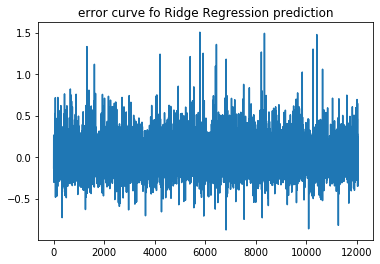

In [12]:
alpha = [0.1,0.5,1.0,2.0,5.0,10.0,15.0]
param_grid = dict(alpha = alpha)
kflod = KFold(n_splits=10, shuffle = True)
model = Ridge()
grid_search = GridSearchCV(model,param_grid,scoring = 'neg_mean_squared_error',n_jobs = -1,cv = kflod,verbose=True)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
Y_pred_test = grid_search.best_estimator_.predict(X_test)
print("MSE of Ridge Regression prediction for Test Data = %f" % mean_squared_error(Y_pred_test,y_test))
print("MAPE of Ridge Regression prediction for Test Data = %f" % mape(Y_pred_test,y_test), '%')
plt.plot(np.array(y_test)-Y_pred_test)
plt.title('error curve fo Ridge Regression prediction')
plt.show()


## 2.2 Gradient Boosting Decision Tree

#### Ensemble learning integrates multiple machine learning algorithms into a strong learner, ensemble forecast of height can use LightGBM, which is a type of Gradient Boosting Decision Tree, and the trees are regression trees. GBDT is used for regression prediction, and can also be used for classification with threshold setting. There is a variety of distinguishing features and feature combinations. GBDT accumulates the results of all trees to make the final prediction. The core of GBDT is that each tree learns the residual (negative gradient) of the sum of all the previous tree results. 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.3min finished


Best: -0.026145 using {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 50}
MSE of LightGBM prediction for Test Data = 0.026052
MAPE of LightGBM prediction for Test Data = 12.104327 %


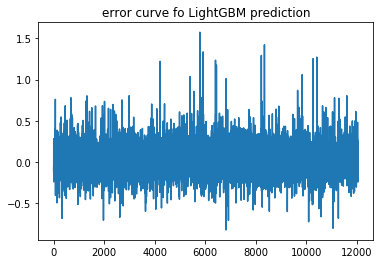

In [15]:
model = lgb.LGBMRegressor(objective='regression',random_state=11)
learning_rate = [0.01,0.1,0.5,1.0]
num_leaves = [20,30,50,80]
n_estimators = [20,50,200]
kflod = KFold(n_splits=5, shuffle = True)
param_grid = dict(learning_rate = learning_rate,n_estimators = n_estimators,num_leaves = num_leaves)
grid_search = GridSearchCV(model,param_grid,scoring = 'neg_mean_squared_error',n_jobs = -1,cv = kflod,verbose=True)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
Y_pred_test = grid_search.best_estimator_.predict(X_test)
print("MSE of LightGBM prediction for Test Data = %f" % mean_squared_error(Y_pred_test,y_test))
print("MAPE of LightGBM prediction for Test Data = %f" % mape(Y_pred_test,y_test), '%')
plt.plot(np.array(y_test)-Y_pred_test)
plt.title('error curve fo LightGBM prediction')
plt.show()

## 2.3 KNN

#### When using KNN for regression, we choose the averaging method, that is, the average value of the sample output of the nearest K samples as the regression prediction value.

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   16.8s finished


Best: -0.027015 using {'n_neighbors': 20}
MSE of KNN prediction for Test Data = 0.027051
MAPE of KNN prediction for Test Data = 12.398089 %


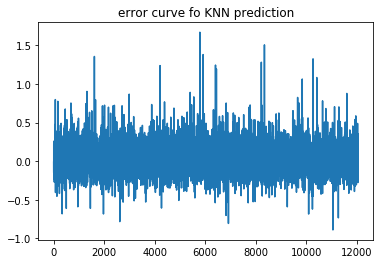

In [16]:
model = KNeighborsRegressor()
kflod = KFold(n_splits = 5, shuffle = True)
n_neighbors = [5,6,7,8,9,10,20]
param_grid ={"n_neighbors": n_neighbors}
grid_search = GridSearchCV(model,param_grid,scoring = 'neg_mean_squared_error',n_jobs = -1,cv = kflod,verbose=True)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
Y_pred_test = grid_search.best_estimator_.predict(X_test)
print("MSE of KNN prediction for Test Data = %f" % mean_squared_error(Y_pred_test,y_test))
print("MAPE of KNN prediction for Test Data = %f" % mape(Y_pred_test,y_test), '%')
plt.plot(np.array(y_test)-Y_pred_test)
plt.title('error curve fo KNN prediction')
plt.show()

# 3.0 Conclusion

### The best model is LightGBM. It is a gradient boosting framework that uses tree based learning algorithms.

#FOR MSE
#MSE of Ridge Regression prediction for Test Data = 0.032580
#MSE of LightGBM prediction for Test Data = 0.026052
#MSE of KNN prediction for Test Data = 0.027051

### LightGBM has the smallest mean square error, followed by KNN, and linear ridge regression has the worst.

#FOR MAPE
#MAPE of Ridge Regression prediction for Test Data = 14.041027 %
#MAPE of LightGBM prediction for Test Data = 12.104327 %
#MAPE of KNN prediction for Test Data = 12.398089 %

### LightGBM also has the best result. 
